In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
import xgboost as xgb

/Users/litingliu/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [3]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [6]:
bmi_mean = df.bmi.mean()

In [7]:
# fill na with the mean of bmi
df.bmi = df.bmi.fillna(bmi_mean)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                5110 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [9]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.698018,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.800000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.400000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,32.800000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [17]:
numerical = ['age', 'avg_glucose_level', 'bmi']
categorical = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'residence_type', 'smoking_status']

In [10]:
def barplotsColumns(autos,nLower = 2,nUpper = 100):
    nColumns = 3
    autos = autos[[col for col in autos if autos.nunique()[col] > nLower and autos.nunique()[col] < nUpper]] 
    _, nCol = autos.shape
    nGraphRow = (nCol + nColumns - 1) / nColumns
    fig = plt.figure(num = None, figsize = (7 * 6, int(4 * nGraphRow)), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(nCol):
        plt.subplot(int(nGraphRow), nColumns, i + 1)
        columnDf = autos.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('Counts')
        plt.title('{}'.format(list(autos)[i]))
        
    fig.savefig('high_view.jpg')

    plt.show()

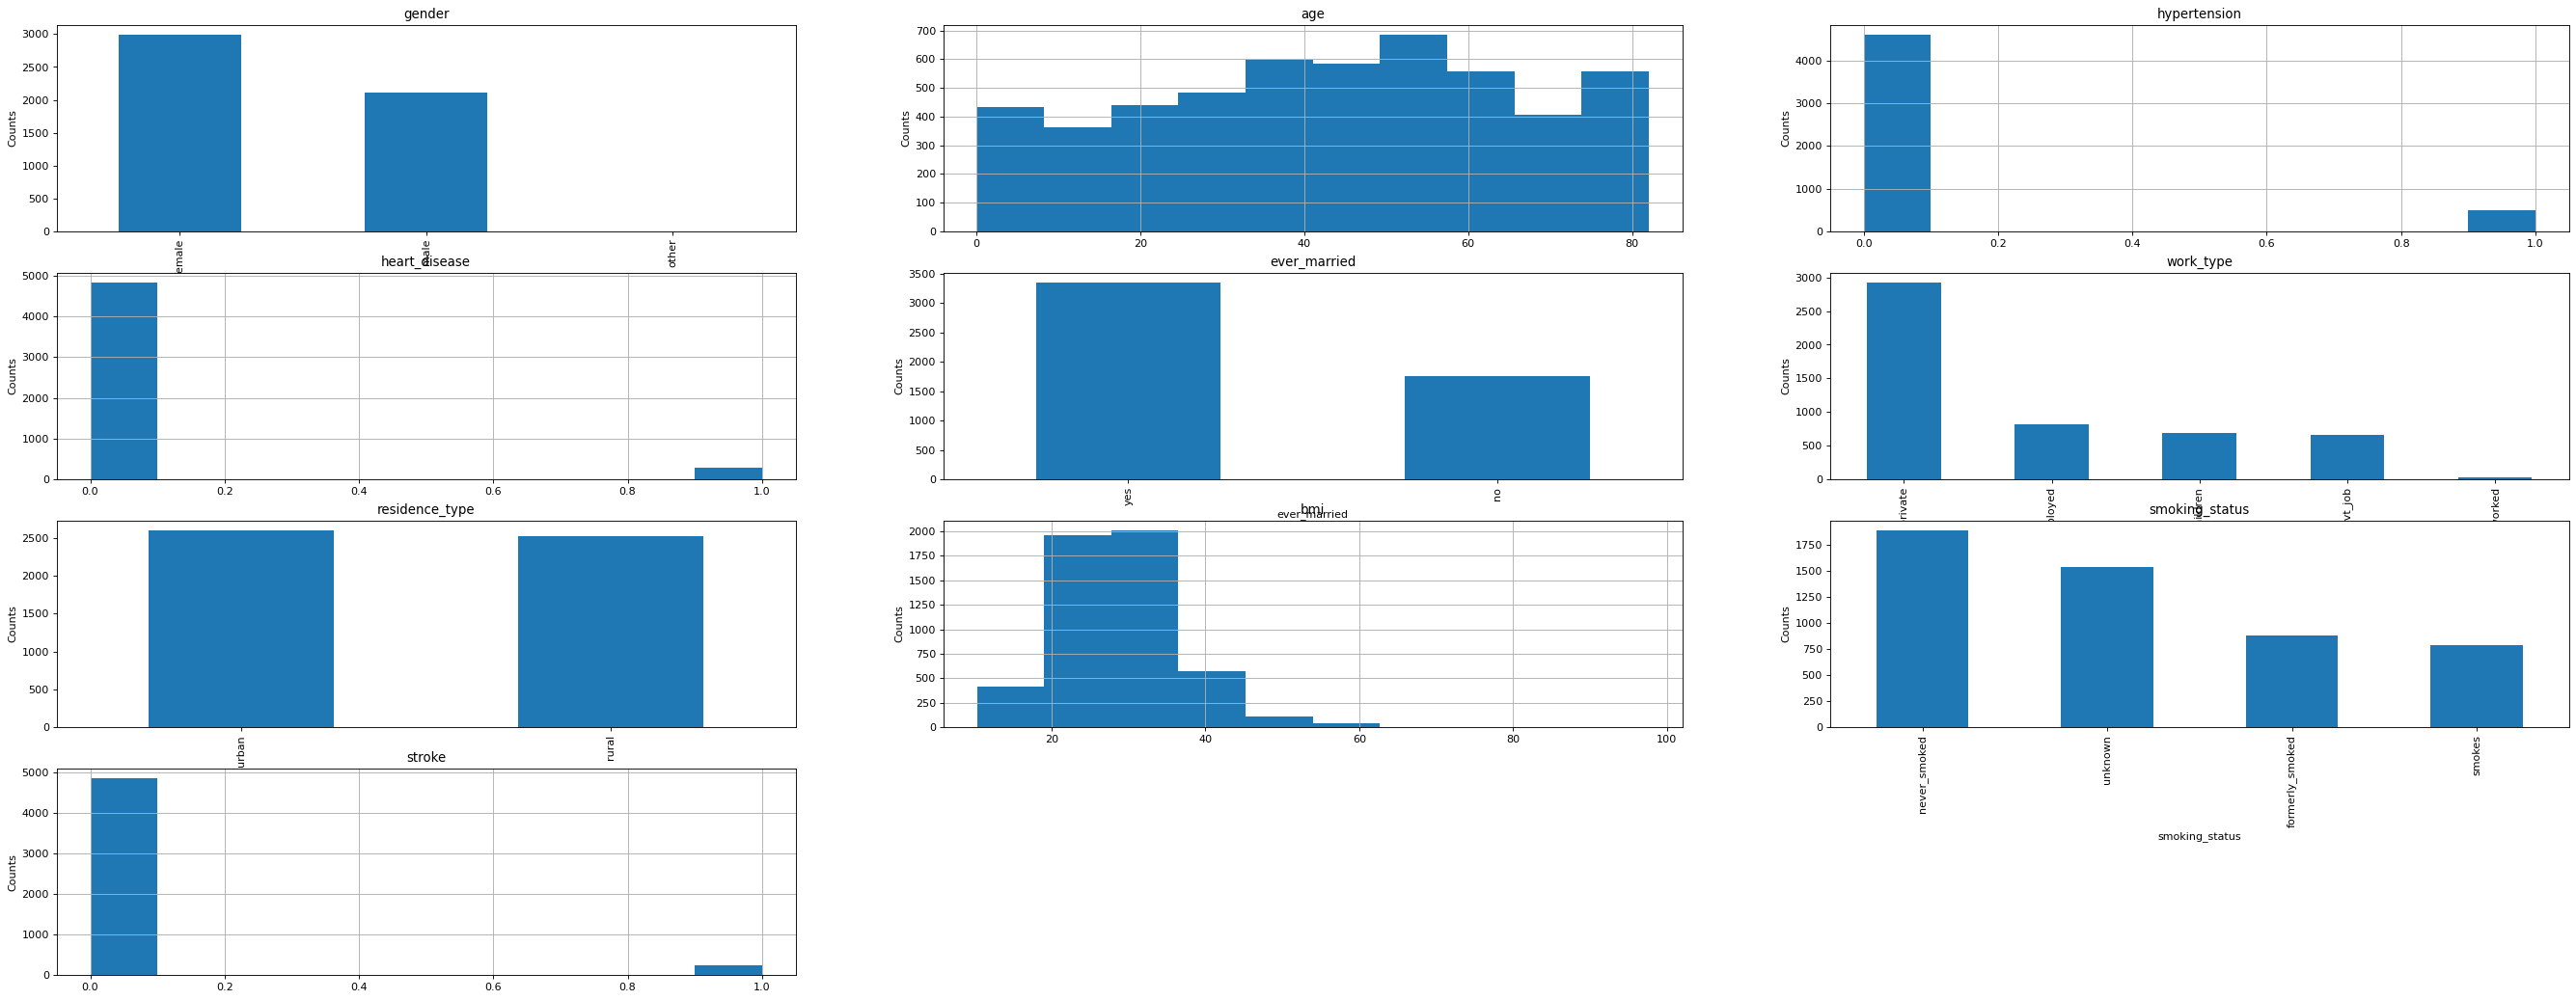

In [11]:
barplotsColumns(df, nLower = 1, nUpper = 1000)

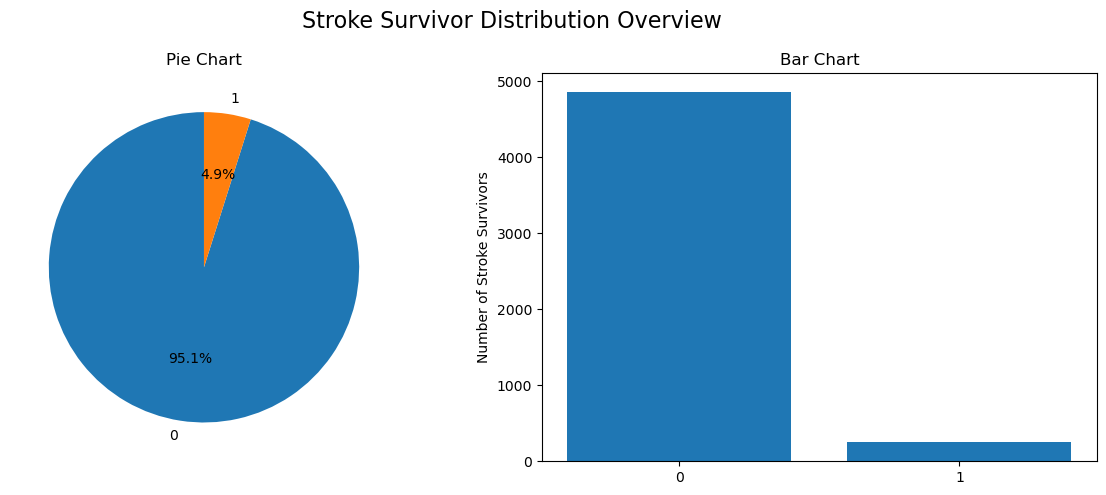

In [12]:
# Stroke distribution
target = 'stroke'
labels=[0,1]
stroke_counts = df[target].value_counts()

# 2 subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Pie Chart
ax[0].pie(stroke_counts.values, labels=labels, autopct='%1.1f%%', startangle=90)
ax[0].set_title('Pie Chart')

# Bar Chart
ax[1].bar(stroke_counts.index, stroke_counts.values)
ax[1].set_xticks([0, 1])
ax[1].set_xticklabels(labels)
# ax[1].set_xlabel('Churn')
ax[1].set_ylabel('Number of Stroke Survivors')
ax[1].set_title('Bar Chart')

# Better layout
fig.suptitle('Stroke Survivor Distribution Overview', fontsize=16)
plt.tight_layout()
plt.show()

fig.savefig('Stroke_Survivor_Distribution_Overview.jpg')

In [13]:
stroke_counts

stroke
0    4861
1     249
Name: count, dtype: int64

In [14]:
# Correlation analysis

In [18]:
df[numerical].corrwith(df.stroke)

age                  0.245257
avg_glucose_level    0.131945
bmi                  0.038947
dtype: float64

<Figure size 1200x800 with 0 Axes>

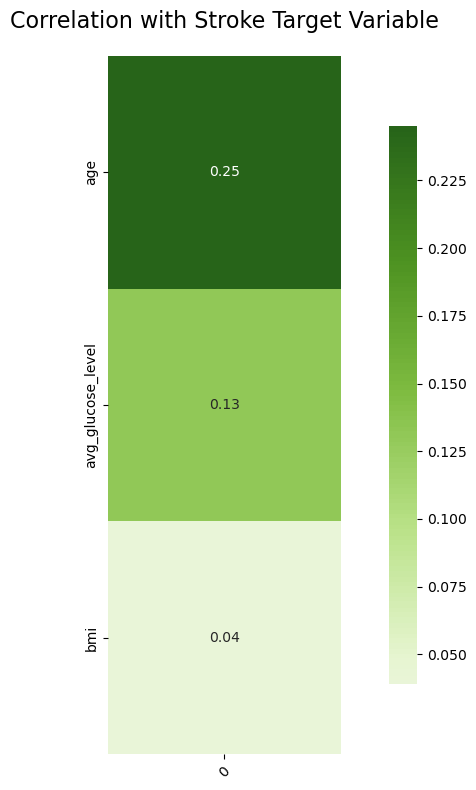

In [32]:

plt.figure(figsize=(12, 8))

correlations = df[numerical].corrwith(df.stroke).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(correlations.to_frame(), 
            annot=True, 
            cmap='PiYG', 
            fmt=".2f",
            center=0,
            square=True,
            cbar_kws={'shrink': 0.8})

plt.title('Correlation with Stroke Target Variable', fontsize=16, pad=20)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

fig.savefig('correlation_heatmap.png') 

In [14]:
# Data split

In [114]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

In [19]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [20]:
y_train = (df_train.stroke).astype('int').values
y_val = (df_val.stroke).astype('int').values
y_test = (df_test.stroke).astype('int').values

In [21]:
del df_train['stroke']
del df_val['stroke']
del df_test['stroke']

In [22]:
# MI

In [23]:
from sklearn.metrics import mutual_info_score

In [24]:
def mutual_info_stroke_score(series):
    return mutual_info_score(series, df_full_train.stroke)

In [25]:
mi =df_full_train[categorical].apply(mutual_info_stroke_score)
mi.sort_values(ascending = False)

ever_married      0.007264
work_type         0.006085
heart_disease     0.005525
hypertension      0.005202
smoking_status    0.002798
residence_type    0.000094
gender            0.000092
dtype: float64

In [26]:
# One-hot encoding

In [27]:
from sklearn.feature_extraction import DictVectorizer

In [28]:
dicts_train = df_train[categorical+numerical].to_dict(orient = "records")

In [29]:
dv = DictVectorizer(sparse = False)

In [30]:
X_train = dv.fit_transform(dicts_train)
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [31]:
# Simpel resample (duplicating minority)

In [32]:
def simple_oversample(X_train, y_train):
    """Simple random oversampling"""
    X_train_df = pd.DataFrame(X_train)
    X_train_df['target'] = y_train
    
    # Separate majority and minority classes
    majority = X_train_df[X_train_df.target == 0]
    minority = X_train_df[X_train_df.target == 1]
    
    # Oversample minority class
    minority_upsampled = resample(
        minority,
        replace=True,
        n_samples=len(majority),
        random_state=42
    )
    
    # Combine
    upsampled = pd.concat([majority, minority_upsampled])
    upsampled = upsampled.sample(frac=1, random_state=42).reset_index(drop=True)
    
    y_resampled = upsampled['target'].values
    X_resampled = upsampled.drop('target', axis=1).values
    
    return X_resampled, y_resampled

In [33]:
# SMOTE

In [34]:
def smote_oversample(X_train, y_train):
    """SMOTE oversampling"""
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    return X_resampled, y_resampled

In [35]:
# SMOTETomek

In [36]:
def smotetomek_resample(X_train, y_train):
    """SMOTE + Tomek links"""
    smt = SMOTETomek(random_state=42)
    X_resampled, y_resampled = smt.fit_resample(X_train, y_train)
    return X_resampled, y_resampled

In [37]:
# Train and eval with different resampling method

In [38]:
def train_xgboost(X_train, y_train, X_val, y_val, eta_values, method_name, 
                  use_scale_pos_weight=False, max_iterations=200):
    """Train XGBoost with different eta values and track AUC"""
    results = {}
    
    for eta in eta_values:
        print(f"\nTraining {method_name} with eta={eta}...")
        
        # Calculate scale_pos_weight if needed
        scale_weight = None
        if use_scale_pos_weight:
            scale_weight = np.bincount(y_train)[0] / np.bincount(y_train)[1]
            print(f"Using scale_pos_weight={scale_weight:.2f}")
        
        # XGBoost parameters with regularization
        params = {
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'eta': eta,
            'max_depth': 4,  
            'min_child_weight': 5,  
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'gamma': 1,  # Minimum loss reduction
            'lambda': 1,  # L2 regularization
            'alpha': 0.1,  # L1 regularization
            'random_state': 42
        }
        
        if scale_weight:
            params['scale_pos_weight'] = scale_weight
        
        # Create DMatrix
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dval = xgb.DMatrix(X_val, label=y_val)
        
        # Track AUC at each iteration
        evals_result = {}
        evallist = [(dtrain, 'train'), (dval, 'val')]
        
        # Train model
        model = xgb.train(
            params,
            dtrain,
            num_boost_round=max_iterations,
            evals=evallist,
            evals_result=evals_result,
            verbose_eval=False
        )
        
        results[eta] = {
            'train_auc': evals_result['train']['auc'],
            'val_auc': evals_result['val']['auc'],
            'model': model
        }
        
        # Find best iteration
        best_iter = np.argmax(evals_result['val']['auc'])
        best_auc = evals_result['val']['auc'][best_iter]
        print(f"Best test AUC: {best_auc:.4f} at iteration {best_iter}")
    
    return results

In [39]:
# Viz

In [40]:
def plot_comparison(results_dict, title):
    """Plot AUC curves for different eta values"""
    plt.figure(figsize=(12, 5))
    
    # Plot test AUC
    plt.subplot(1, 2, 1)
    for eta, data in results_dict.items():
        plt.plot(data['val_auc'], label=f'eta={eta}')
    plt.xlabel('Iteration')
    plt.ylabel('Val AUC')
    plt.title(f'{title} - Val AUC')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot train AUC
    plt.subplot(1, 2, 2)
    for eta, data in results_dict.items():
        plt.plot(data['train_auc'], label=f'eta={eta}')
    plt.xlabel('Iteration')
    plt.ylabel('Train AUC')
    plt.title(f'{title} - Train AUC')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


In [41]:
# Run experiment


EXPERIMENT 1: No Resampling + scale_pos_weight

Training No Resampling with eta=0.05...
Using scale_pos_weight=21.38
Best test AUC: 0.8266 at iteration 11

Training No Resampling with eta=0.01...
Using scale_pos_weight=21.38
Best test AUC: 0.8251 at iteration 8

Training No Resampling with eta=0.005...
Using scale_pos_weight=21.38
Best test AUC: 0.8245 at iteration 8

Training No Resampling with eta=0.001...
Using scale_pos_weight=21.38
Best test AUC: 0.8248 at iteration 6


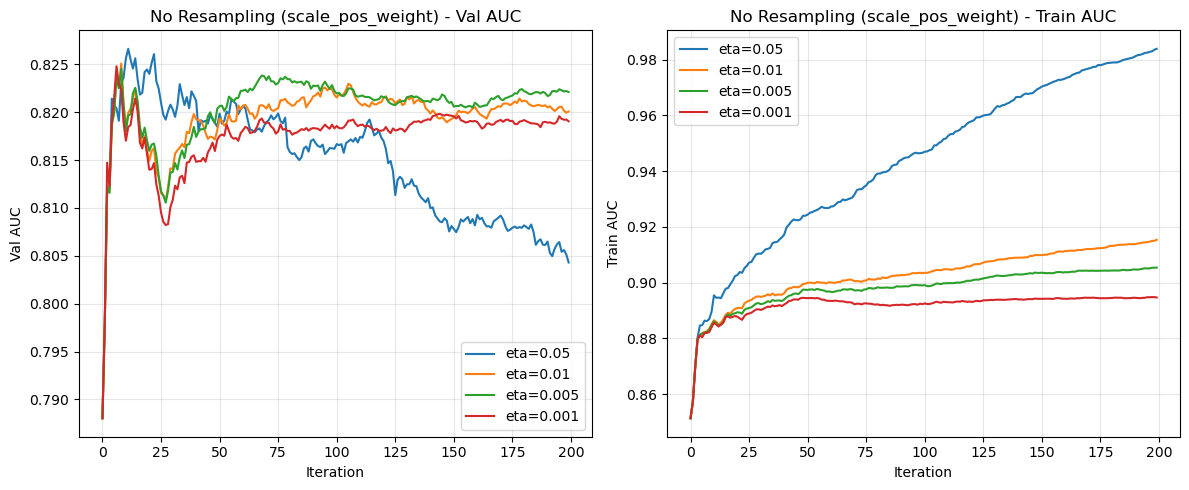


EXPERIMENT 2: Simple Oversampling (Your Original Method)
After oversampling: [2929 2929]

Training Simple Oversample with eta=0.05...
Best test AUC: 0.8156 at iteration 0

Training Simple Oversample with eta=0.01...
Best test AUC: 0.8168 at iteration 2

Training Simple Oversample with eta=0.005...
Best test AUC: 0.8168 at iteration 2

Training Simple Oversample with eta=0.001...
Best test AUC: 0.8168 at iteration 2


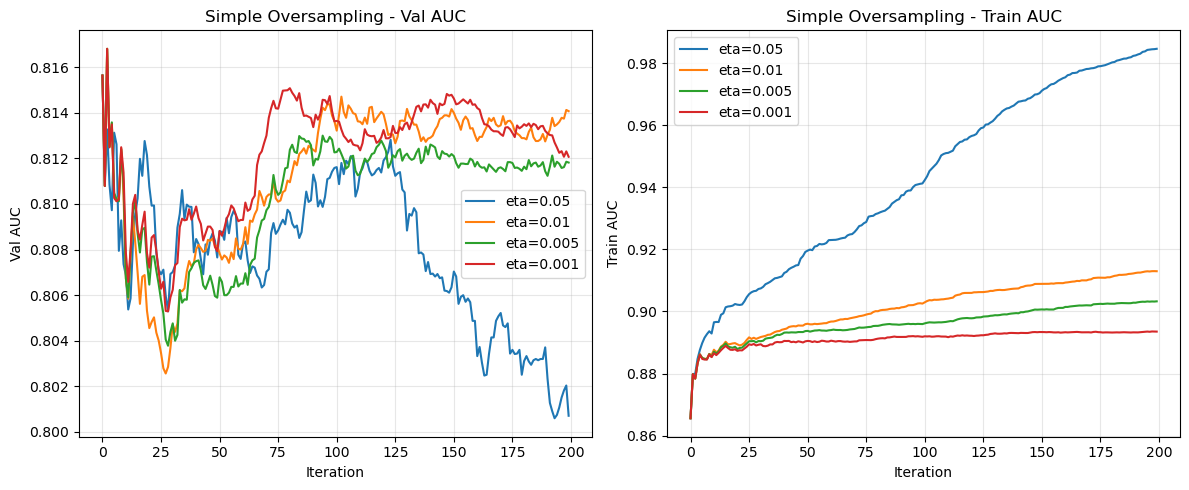


EXPERIMENT 3: SMOTE
After SMOTE: [2929 2929]

Training SMOTE with eta=0.05...
Best test AUC: 0.8318 at iteration 41

Training SMOTE with eta=0.01...
Best test AUC: 0.8275 at iteration 141

Training SMOTE with eta=0.005...
Best test AUC: 0.8183 at iteration 199

Training SMOTE with eta=0.001...
Best test AUC: 0.8163 at iteration 39


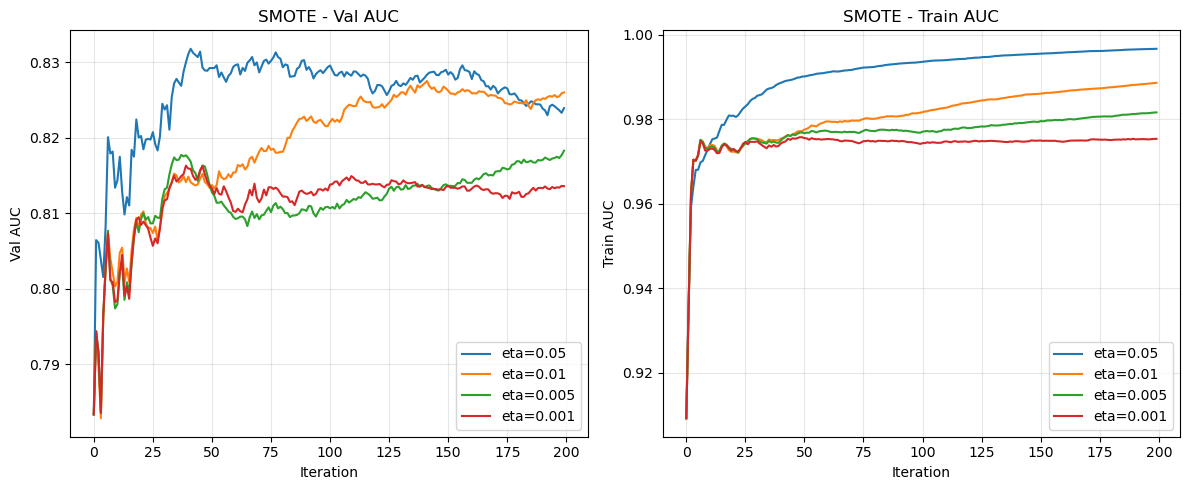


EXPERIMENT 4: SMOTETomek
After SMOTETomek: [2899 2899]

Training SMOTETomek with eta=0.05...
Best test AUC: 0.8297 at iteration 103

Training SMOTETomek with eta=0.01...
Best test AUC: 0.8237 at iteration 183

Training SMOTETomek with eta=0.005...
Best test AUC: 0.8203 at iteration 8

Training SMOTETomek with eta=0.001...
Best test AUC: 0.8204 at iteration 8


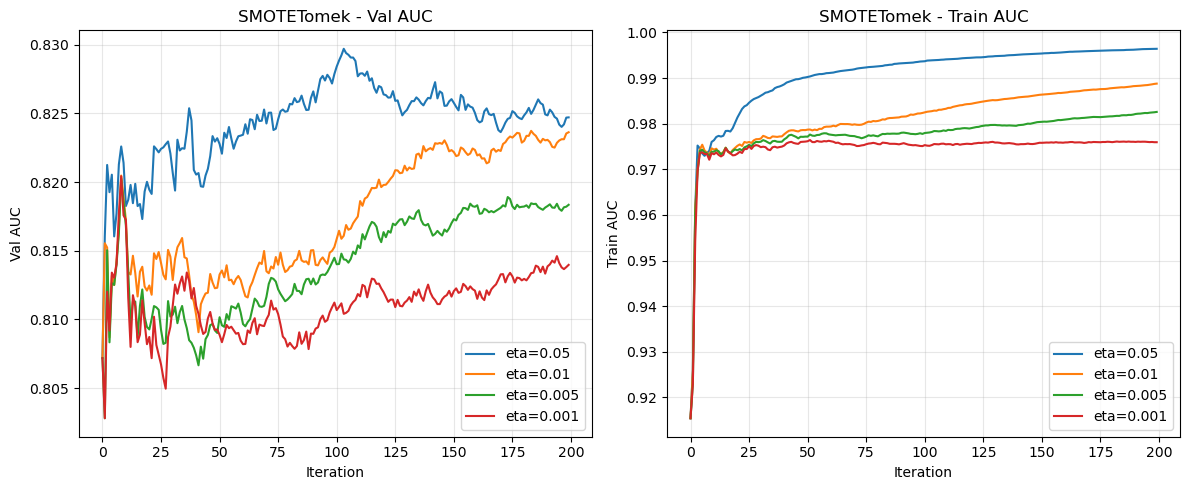

In [42]:
eta_values = [0.05, 0.01, 0.005, 0.001]

print("\n" + "="*60)
print("EXPERIMENT 1: No Resampling + scale_pos_weight")
print("="*60)
results_no_resample = train_xgboost(
    X_train, y_train, X_val, y_val, 
    eta_values, 
    "No Resampling", 
    use_scale_pos_weight=True
)
plot_comparison(results_no_resample, "No Resampling (scale_pos_weight)")

print("\n" + "="*60)
print("EXPERIMENT 2: Simple Oversampling (Your Original Method)")
print("="*60)
X_train_over, y_train_over = simple_oversample(X_train, y_train)
print(f"After oversampling: {np.bincount(y_train_over)}")
results_oversample = train_xgboost(
    X_train_over, y_train_over,X_val, y_val, 
    eta_values, 
    "Simple Oversample"
)
plot_comparison(results_oversample, "Simple Oversampling")

print("\n" + "="*60)
print("EXPERIMENT 3: SMOTE")
print("="*60)
X_train_smote, y_train_smote = smote_oversample(X_train, y_train)
print(f"After SMOTE: {np.bincount(y_train_smote)}")
results_smote = train_xgboost(
    X_train_smote, y_train_smote, X_val, y_val, 
    eta_values, 
    "SMOTE"
)
plot_comparison(results_smote, "SMOTE")

print("\n" + "="*60)
print("EXPERIMENT 4: SMOTETomek")
print("="*60)
X_train_smt, y_train_smt = smotetomek_resample(X_train, y_train)
print(f"After SMOTETomek: {np.bincount(y_train_smt)}")
results_smotetomek = train_xgboost(
    X_train_smt, y_train_smt, X_val, y_val, 
    eta_values, 
    "SMOTETomek"
)
plot_comparison(results_smotetomek, "SMOTETomek")

It seems SMOTETomek with eta at 0.05 and iteration of 103 has the most stable performance of all. Let's tune max depth next. 

In [45]:
X_train_smt, y_train_smt = smotetomek_resample(X_train, y_train)


In [46]:
dtrain = xgb.DMatrix(X_train_smt, label=y_train_smt)
dval = xgb.DMatrix(X_val, label=y_val)

In [47]:
def parse_xgb_output(output):
    results = []
 
    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')
 
        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])
 
        results.append((it, train, val))
     
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [48]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [49]:
scores = {}

In [50]:
%%capture output

params = {
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'eta': 0.05,
            'max_depth': 4,  
            'min_child_weight': 5,  
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'gamma': 1,  # Minimum loss reduction
            'lambda': 1,  # L2 regularization
            'alpha': 0.1,  # L1 regularization
            'random_state': 42
        }



model = xgb.train(
            params,
            dtrain,
            num_boost_round=103,
            verbose_eval=5,
            evals=watchlist
        )

In [52]:
key = 'max_depth=%s' % (params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=4'

In [53]:
%%capture output

params = {
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'eta': 0.05,
            'max_depth': 3,  
            'min_child_weight': 5,  
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'gamma': 1,  # Minimum loss reduction
            'lambda': 1,  # L2 regularization
            'alpha': 0.1,  # L1 regularization
            'random_state': 42
        }



model = xgb.train(
            params,
            dtrain,
            num_boost_round=103,
            verbose_eval=5,
            evals=watchlist
        )

In [54]:
key = 'max_depth=%s' % (params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=3'

In [55]:
%%capture output

params = {
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'eta': 0.05,
            'max_depth': 2,  
            'min_child_weight': 5,  
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'gamma': 1,  # Minimum loss reduction
            'lambda': 1,  # L2 regularization
            'alpha': 0.1,  # L1 regularization
            'random_state': 42
        }



model = xgb.train(
            params,
            dtrain,
            num_boost_round=103,
            verbose_eval=5,
            evals=watchlist
        )

In [56]:
key = 'max_depth=%s' % (params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=2'

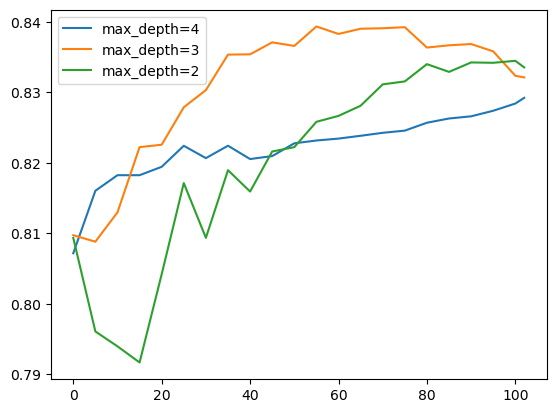

In [57]:
for key, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=key)
plt.legend()

So, max_depth = 3 is the best. Let's turn mid child weight.

In [58]:
scores = {}

In [59]:
%%capture output

params = {
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'eta': 0.05,
            'max_depth': 3,  
            'min_child_weight': 3,  
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'gamma': 1,  # Minimum loss reduction
            'lambda': 1,  # L2 regularization
            'alpha': 0.1,  # L1 regularization
            'random_state': 42
        }



model = xgb.train(
            params,
            dtrain,
            num_boost_round=103,
            verbose_eval=5,
            evals=watchlist
        )

In [62]:
key = 'min_child_weight=%s' % (params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

'min_child_weight=3'

In [63]:
%%capture output

params = {
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'eta': 0.05,
            'max_depth': 3,  
            'min_child_weight': 5,  
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'gamma': 1,  # Minimum loss reduction
            'lambda': 1,  # L2 regularization
            'alpha': 0.1,  # L1 regularization
            'random_state': 42
        }



model = xgb.train(
            params,
            dtrain,
            num_boost_round=103,
            verbose_eval=5,
            evals=watchlist
        )

In [64]:
key = 'min_child_weight=%s' % (params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

'min_child_weight=5'

In [65]:
%%capture output

params = {
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'eta': 0.05,
            'max_depth': 3,  
            'min_child_weight': 7,  
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'gamma': 1,  # Minimum loss reduction
            'lambda': 1,  # L2 regularization
            'alpha': 0.1,  # L1 regularization
            'random_state': 42
        }



model = xgb.train(
            params,
            dtrain,
            num_boost_round=103,
            verbose_eval=5,
            evals=watchlist
        )

In [66]:
key = 'min_child_weight=%s' % (params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

'min_child_weight=7'

In [67]:
%%capture output

params = {
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'eta': 0.05,
            'max_depth': 3,  
            'min_child_weight': 10,  
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'gamma': 1,  # Minimum loss reduction
            'lambda': 1,  # L2 regularization
            'alpha': 0.1,  # L1 regularization
            'random_state': 42
        }



model = xgb.train(
            params,
            dtrain,
            num_boost_round=103,
            verbose_eval=5,
            evals=watchlist
        )

In [68]:
key = 'min_child_weight=%s' % (params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

'min_child_weight=10'

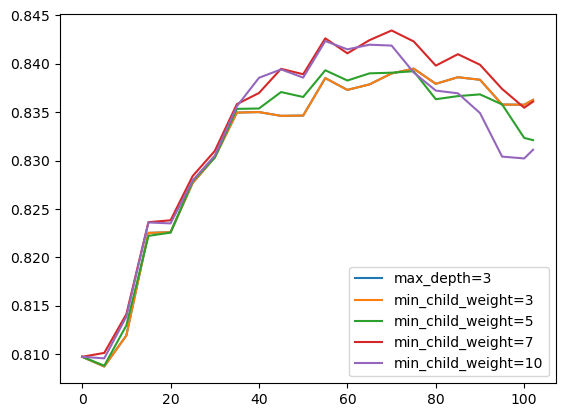

In [71]:
for min_child_weight, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=min_child_weight)
plt.legend()

min_child_weight = 7 is the best.

In [76]:
key = 'min_child_weight=7'
scores[key]

,num_iter,train_auc,val_auc
0,0,0.87942,0.80974
1,5,0.95537,0.81014
2,10,0.96095,0.81414
3,15,0.96455,0.82365
4,20,0.96827,0.82384
5,25,0.97277,0.82841
6,30,0.97620,0.83100
7,35,0.97922,0.83584
8,40,0.98169,0.83699
9,45,0.98456,0.83949


The best number of iteration is about 70.

In [112]:
# Final Model

In [115]:
df_full_train = df_full_train.reset_index(drop=True)
y_full_train = (df_full_train.stroke == 1).astype(int).values
del df_full_train['stroke']

In [116]:
X_full_train_smt, y_full_train_smt = smotetomek_resample(X_full_train, y_full_train)

In [117]:
dicts_full_train = df_full_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

In [118]:
feature_names = list(dv.get_feature_names_out())

In [119]:
dfulltrain = xgb.DMatrix(X_full_train_smt, label=y_full_train_smt, 
                        feature_names=feature_names)

In [120]:
dicts_test = df_test.to_dict(orient='records')
X_test = dv.transform(dicts_test)
dtest = xgb.DMatrix(X_test, feature_names=feature_names)

In [121]:
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'eta': 0.05,
    'max_depth': 3,  
    'min_child_weight': 7,  
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 1,
    'lambda': 1,
    'alpha': 0.1,
    'random_state': 42
}

model = xgb.train(params, dfulltrain, num_boost_round=70, verbose_eval=5)

In [122]:
y_pred = model.predict(dtest)
roc_auc_score(y_test, y_pred)

0.8477390241609477

The performance is similar to the one in validation. Sucess!!!